## Notebook to test the fixed annual cycle

In [1]:
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
import nc_time_axis
import numpy as np

#plt.rcParams['axes.facecolor']='black'
#plt.style.use('dark_background')
plt.style.use('default')

plt.rcParams.update({'font.size': 20})

In [2]:
path   = "/data/dkamm/nemo_output/DINO/"

## Load domain (not lazy)

In [3]:
from pathlib import Path
import xnemogcm as xn

In [4]:
datadir_semi    = Path(path + '../NEVERWORLD/GAUS_RIDGE_init/restart7')
datadir_annual  = Path(path + 'AnnualCycle/restart7')

In [5]:
domcfg_semi = xn.open_domain_cfg(datadir=datadir_semi)
domcfg_annual   = xn.open_domain_cfg(datadir=datadir_annual  )

In [6]:
domcfg_semi

<xarray.Dataset>
Dimensions:       (y_c: 199, x_c: 60, x_f: 60, y_f: 199, z_c: 36, z_f: 36)
Coordinates: (12/18)
    glamt         (y_c, x_c) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    glamu         (y_c, x_f) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    glamv         (y_f, x_c) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    glamf         (y_f, x_f) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    gphit         (y_c, x_c) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    gphiu         (y_c, x_f) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    ...            ...
  * x_c           (x_c) int64 0 1 2 3 4 5 6 7 8 9 ... 51 52 53 54 55 56 57 58 59
  * y_c           (y_c) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
  * x_f           (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 55.5 56.5 57.5 58.5 59.5
  * y_f           (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 195.5 196.5 197.5 198.5
  * z_c           (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 27 28 29 30 31 32 33 34 35
  * z_f           (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 31.5 32.5 33.5 34.5
Data variables: (12/31)
    e1t           (y_c, x_c) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    e1u           (y_c, x_f) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    e1v           (y_f, x_c) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    e1f           (y_f, x_f) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    e2t           (y_c, x_c) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    e2u           (y_c, x_f) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    ...            ...
    fmask         (z_c, y_f, x_f) int8 dask.array<chunksize=(36, 17, 20), meta=np.ndarray>
    tmaskutil     (y_c, x_c) int8 dask.array<chunksize=(17, 20), meta=np.ndarray>
    umaskutil     (y_c, x_f) int8 dask.array<chunksize=(17, 20), meta=np.ndarray>
    vmaskutil     (y_f, x_c) int8 dask.array<chunksize=(17, 20), meta=np.ndarray>
    mbathy        (y_c, x_c) int32 dask.array<chunksize=(17, 20), meta=np.ndarray>
    misf          (y_c, x_c) int32 dask.array<chunksize=(17, 20), meta=np.ndarray>
Attributes: (12/13)
    DOMAIN_dimensions_ids:   [1 2]
    DOMAIN_size_global:      [ 60 199]
    DOMAIN_halo_size_start:  [0 0]
    DOMAIN_halo_size_end:    [0 0]
    DOMAIN_type:             BOX
    CfgName:                 BASIN
    ...                      ...
    Iperio:                  1
    Jperio:                  0
    NFold:                   0
    NFtype:                  -
    VertCoord:               sco
    IsfCav:                  0

In [7]:
Data_annual = xn.open_nemo(domcfg=domcfg_annual, files=[
        datadir_annual / '../restart7/NEVERWORLD_grid_T.nc',
        datadir_annual / '../restart7/NEVERWORLD_grid_U.nc',
        datadir_annual / '../restart7/NEVERWORLD_grid_V.nc'
    ])

Data_semi = xn.open_nemo(domcfg=domcfg_semi, files=[
        datadir_semi / '../restart7/NEVERWORLD_grid_T.nc',
        datadir_semi / '../restart7/NEVERWORLD_grid_U.nc',
        datadir_semi / '../restart7/NEVERWORLD_grid_V.nc'
    ])

In [8]:
Data_annual_mo = xn.open_nemo(domcfg=domcfg_annual, files=[
        datadir_annual / '../restart7/NEVERWORLD_grid_T_mo.nc'
    ])

Data_semi_mo = xn.open_nemo(domcfg=domcfg_semi, files=[
        datadir_semi / '../restart7/NEVERWORLD_grid_T_mo.nc'
    ])

### Monthly averaged MLD

Text(0.5, 1.04, 'Monthly average over the last ten years: Annual cycle')

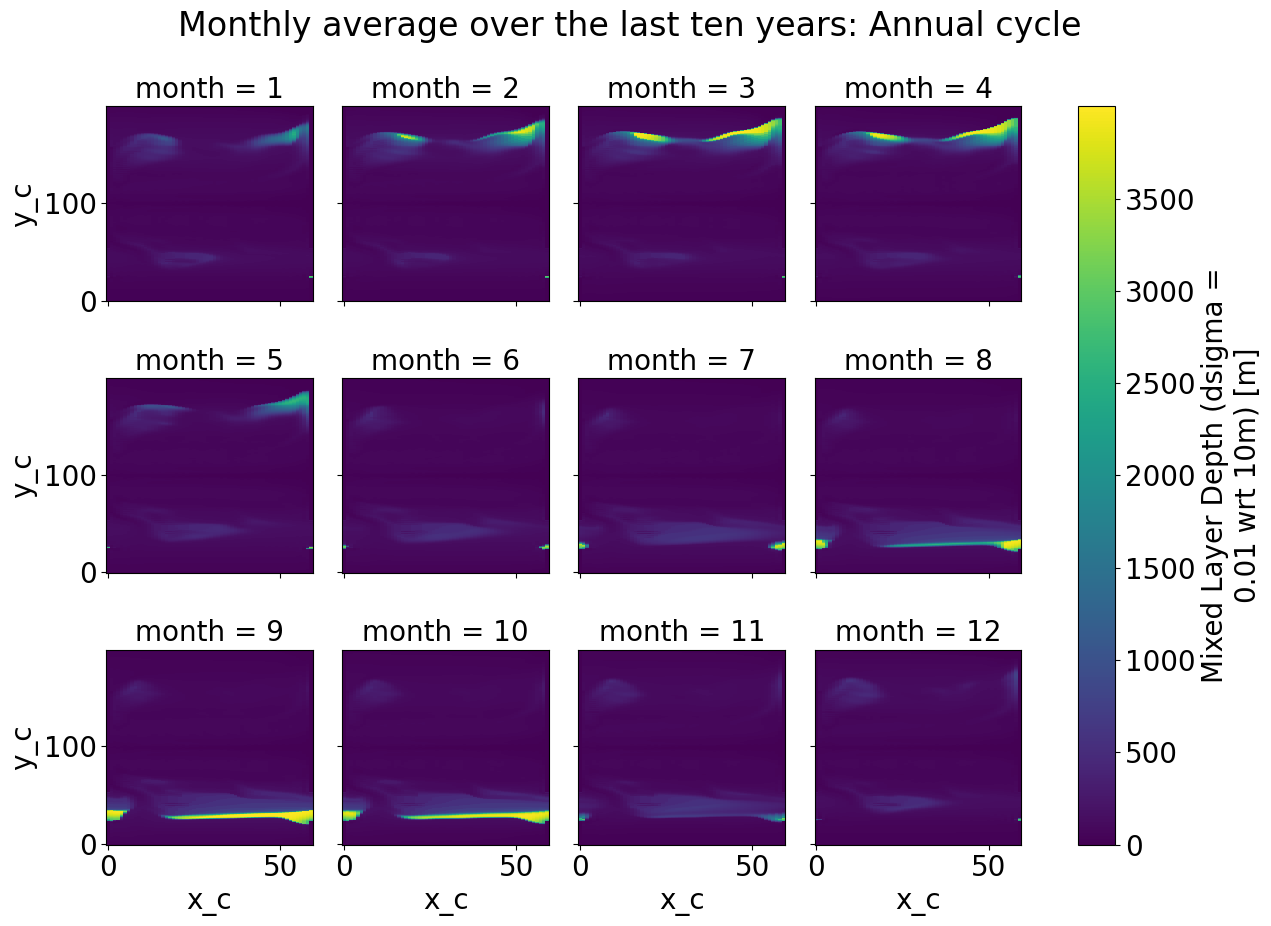

In [9]:
Data_annual_mo.mldr10_1.isel(t=slice(-120,-1)).groupby("t.month").mean().plot(col='month', col_wrap=4)
plt.suptitle('Monthly average over the last ten years: Annual cycle', y=1.04)

Text(0.5, 1.04, 'Monthly average over the last ten years: Semi-annual cycle')

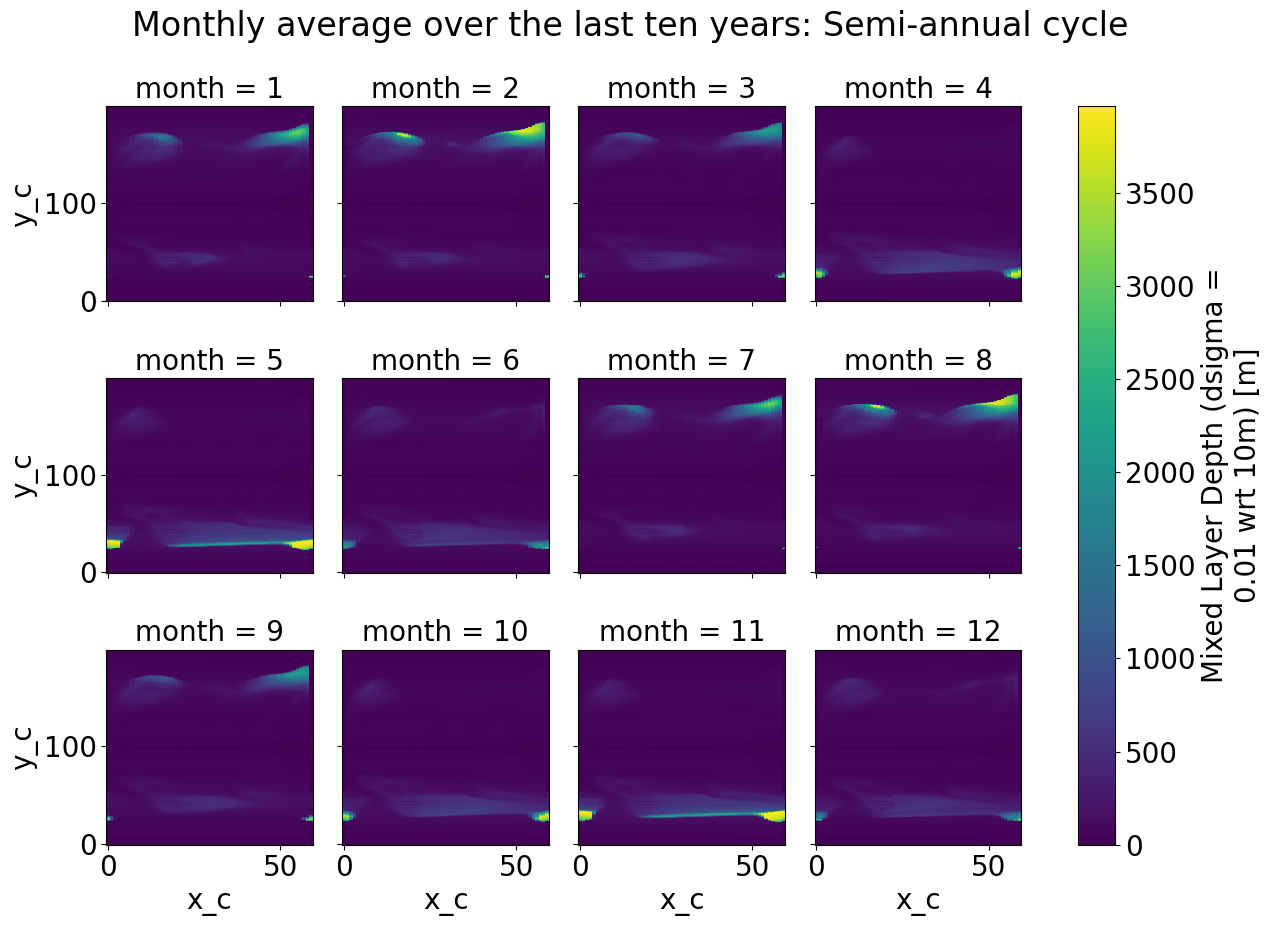

In [10]:
Data_semi_mo.mldr10_1.isel(t=slice(-120,-1)).groupby("t.month").mean().plot(col='month', col_wrap=4)
plt.suptitle('Monthly average over the last ten years: Semi-annual cycle', y=1.04)

### Barotropic Streamfunction

In [11]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0'] # Z distances
}

grid_annual = xgcm.Grid(domcfg_annual,
        coords={
            "X": {"right": "x_f", "center": "x_c"},
            "Y": {"right": "y_f", "center":"y_c"},
            "Z": {"right": "z_f", "center": "z_c"}
        },
        periodic=False,
        metrics=metrics
)

grid_semi = xgcm.Grid(domcfg_semi,
        coords={
            "X": {"right": "x_f", "center": "x_c"},
            "Y": {"right": "y_f", "center":"y_c"},
            "Z": {"right": "z_f", "center": "z_c"}
        },
        periodic=False,
        metrics=metrics
)

In [12]:
#Interpolating on u_f
Data_annual['u_f'] = grid_annual.interp(Data_annual.uoce, 'Y')
Data_semi['u_f'] = grid_semi.interp(Data_semi.uoce, 'Y')

#Integrating over depth
Data_annual['U'] = grid_annual.integrate(Data_annual.u_f, 'Z')
Data_semi['U'] = grid_semi.integrate(Data_semi.u_f, 'Z')

#Cumulative integral over x
Psi_annual = (Data_annual.U[-1,::-1,:] * domcfg_annual.e2f[::-1,:]).cumsum('y_f') / 1e6
Psi_semi = (Data_semi.U[-1,::-1,:] * domcfg_semi.e2f[::-1,:]).cumsum('y_f') / 1e6

Text(0.5, 1.0, 'Annual Cycle')

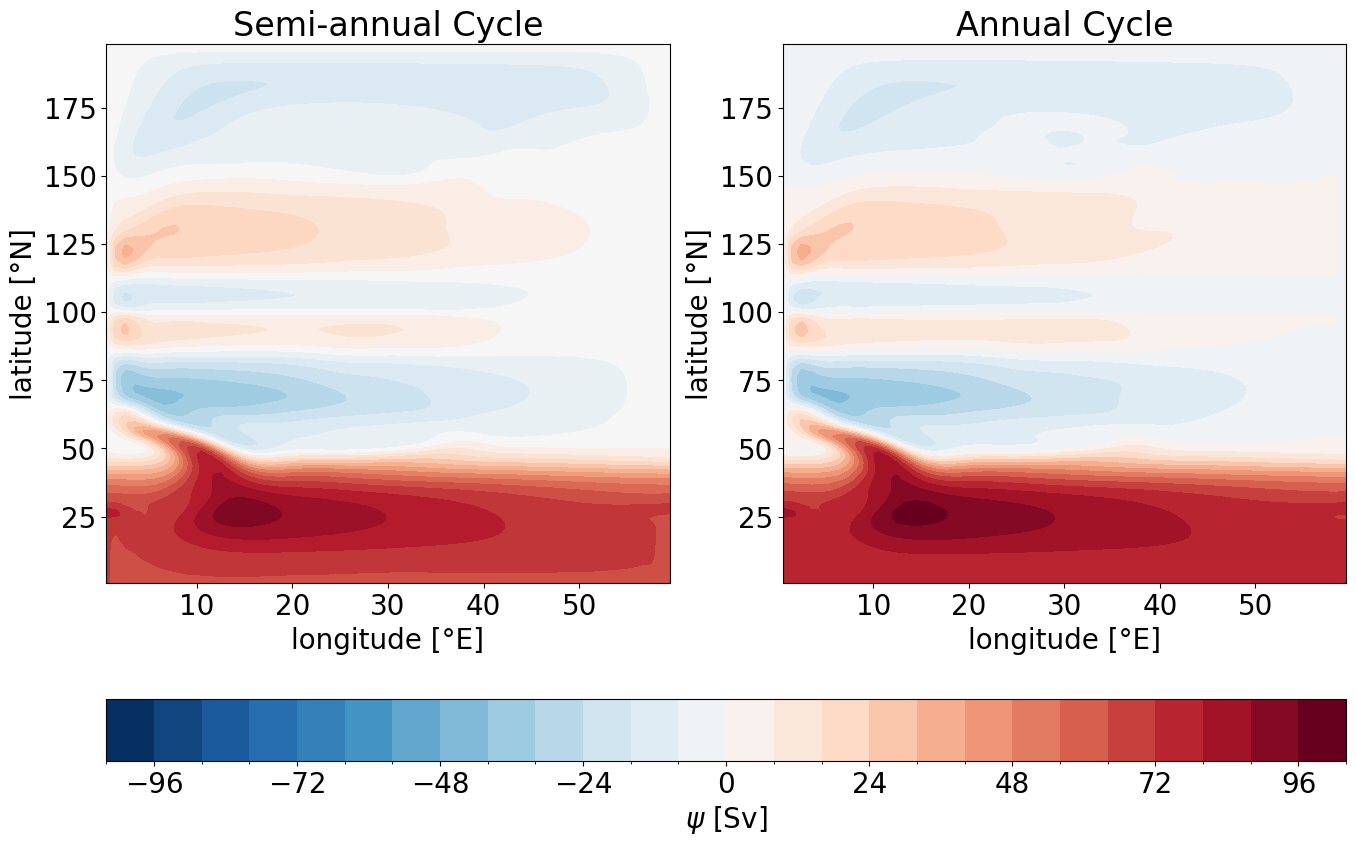

In [13]:
fig, axs = plt.subplots(1,2,figsize=(16,10))
a = Psi_annual.plot.contourf(x='x_f', y='y_f', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[1])
cbar1 = fig.colorbar(a, ax=axs[:2], location='bottom', label=r'$\psi$ [Sv]')
b = Psi_semi.plot.contourf(x='x_f', y='y_f', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[0], vmin=cbar1.vmin, vmax=cbar1.vmax)
axs[0].set_ylabel('latitude [°N]')
axs[1].set_ylabel('latitude [°N]')
axs[0].set_xlabel('longitude [°E]')
axs[1].set_xlabel('longitude [°E]')
axs[0].set_title('Semi-annual Cycle')
axs[1].set_title('Annual Cycle')

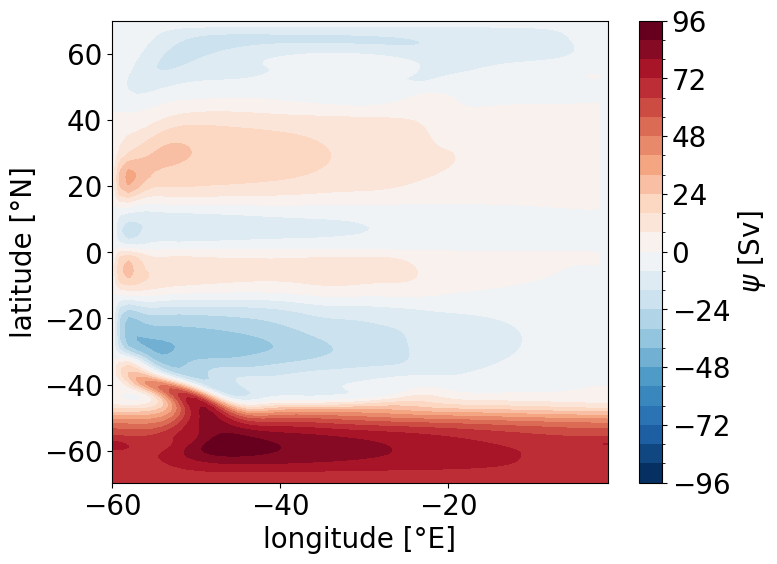

In [14]:
Psi_semi = Psi_semi.assign_coords(dict(
    x_sh=(["y_f", "x_f"], Psi_semi.glamf.values - 60.)
    ))
fig, axs = plt.subplots(1,1,figsize=(8,6))
a = Psi_semi.plot.contourf(x='x_sh', y='gphif', cmap='RdBu_r', levels=30, add_colorbar=False)
cbar1 = fig.colorbar(a, ax=axs, label=r'$\psi$ [Sv]')
axs.set_ylabel('latitude [°N]')
axs.set_xlabel('longitude [°E]')
plt.title('')
axs.set_facecolor('none')
#fig.savefig('BSF.png', transparent=True)

## Stratification

In [15]:
import gsw as gsw

In [16]:
Data_annual['sigma0'] = gsw.sigma0(Data_annual.soce, gsw.CT_from_pt(Data_annual.soce, Data_annual.toce))
Data_semi['sigma0'] = gsw.sigma0(Data_semi.soce, gsw.CT_from_pt(Data_semi.soce, Data_semi.toce))

In [17]:
Data_annual = Data_annual.assign_coords(dict(
    depth_v=(["z_c", "y_f", "x_c"], - Data_annual.isel(t=-1).e3v.cumsum('z_c').values),
    depth_t=(["z_c", "y_c", "x_c"], - Data_annual.isel(t=-1).e3t.cumsum('z_c').values),
    lon_f=(["y_c", "x_f"], domcfg_annual.glamf.values-60.),
    lon_t=(["y_c", "x_c"], domcfg_annual.glamt.values-60.),
    lat_f=(["y_f", "x_c"], domcfg_annual.gphif.values),
    lat_t=(["y_c", "x_c"], domcfg_annual.gphit.values),
    )
)

Data_semi = Data_semi.assign_coords(dict(
    depth_v=(["z_c", "y_f", "x_c"], - Data_semi.isel(t=-1).e3v.cumsum('z_c').values),
    depth_t=(["z_c", "y_c", "x_c"], - Data_semi.isel(t=-1).e3t.cumsum('z_c').values),
    lon_f=(["y_c", "x_f"], domcfg_semi.glamf.values-60.),
    lon_t=(["y_c", "x_c"], domcfg_semi.glamt.values-60.),
    lat_f=(["y_f", "x_c"], domcfg_semi.gphif.values),
    lat_t=(["y_c", "x_c"], domcfg_semi.gphit.values),
    )
)

In [27]:
Data_annual.sigma0.isel(t=-1, x_c=15, z_c=slice(0,25), y_c=slice(1,-1))

<xarray.DataArray 'sigma0' (z_c: 25, y_c: 197)>
dask.array<getitem, shape=(25, 197), dtype=float64, chunksize=(25, 197), chunktype=numpy.ndarray>
Coordinates:
  * z_c            (z_c) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
    time_centered  object dask.array<chunksize=(), meta=np.ndarray>
    t              object 0400-07-01 00:00:00
    x_c            int64 15
  * y_c            (y_c) int64 1 2 3 4 5 6 7 8 ... 191 192 193 194 195 196 197
    gdept_1d       (z_c) float64 dask.array<chunksize=(25,), meta=np.ndarray>
    depth_t        (z_c, y_c) float32 -10.14 -10.14 -10.14 ... -982.2 -982.2
    lon_t          (y_c) float64 -45.5 -45.5 -45.5 -45.5 ... -45.5 -45.5 -45.5
    lat_t          (y_c) float64 -69.5 -69.15 -68.79 -68.43 ... 68.79 69.15 69.5
Attributes:
    standard_name:       sea_water_practical_salinity
    long_name:           salinity
    units:               1e-3
    online_operation:    average
    interval_operation:  2700 s
    interval_write:      1 yr
    cell_methods:        time: mean (interval: 2700 s)

Text(0.5, 0.98, 'Density of the top 1000m')

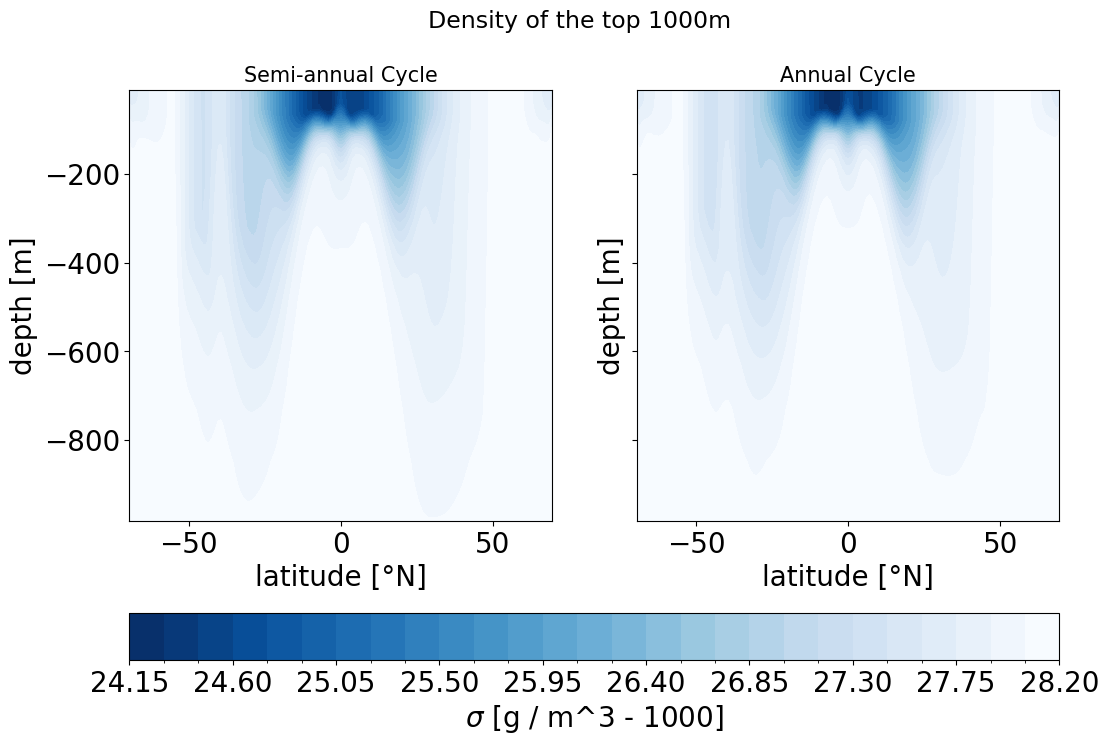

In [29]:
fig, axs = plt.subplots(1,2,figsize=(12,8), sharey=True)
a = (Data_annual.isel(t=-1, x_c=15, z_c=slice(0,25), y_c=slice(1,-1))).sigma0.plot.contourf(x='lat_t', y='depth_t', cmap='Blues_r', levels=30, add_colorbar=False, ax=axs[1])
cbar1 = fig.colorbar(a, ax=axs[:2], location='bottom', label=r'$\sigma$ [g / m^3 - 1000]')
b = (Data_semi.isel(t=-1, x_c=15, z_c=slice(0,25), y_c=slice(1,-1))).sigma0.plot.contourf(x='lat_t', y='depth_t', cmap='Blues_r', levels=30, add_colorbar=False, ax=axs[0], vmin=cbar1.vmin, vmax=cbar1.vmax)
axs[0].set_ylabel('depth [m]')
axs[1].set_ylabel('depth [m]')
axs[0].set_facecolor('grey')
axs[1].set_facecolor('grey')
axs[0].set_xlabel('latitude [°N]')
axs[1].set_xlabel('latitude [°N]')
axs[0].set_title('Semi-annual Cycle', fontsize=15)
axs[1].set_title('Annual Cycle', fontsize=15)
plt.suptitle('Density of the top 1000m', fontsize=17)

Text(0.5, 0.98, 'Density below 1000m')

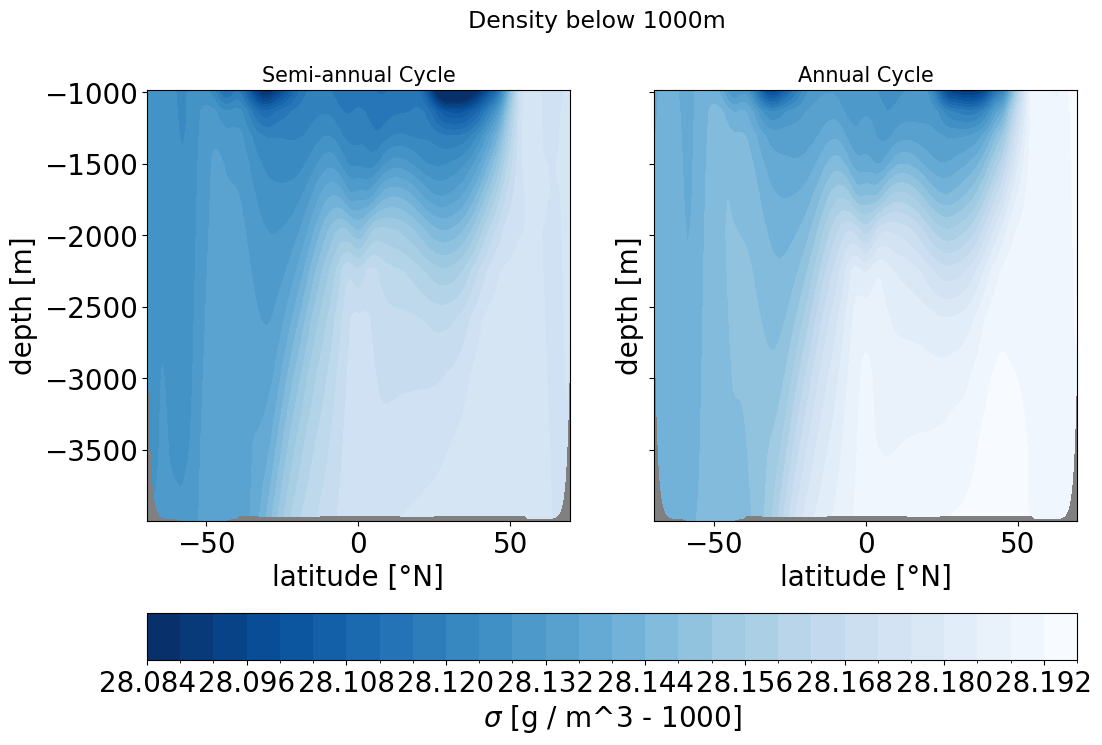

In [30]:
fig, axs = plt.subplots(1,2,figsize=(12,8), sharey=True)
a = (Data_annual.sigma0.isel(t=-1, x_c=15, z_c=slice(24,-1), y_c=slice(1,-1))).plot.contourf(x='lat_t', y='depth_t', cmap='Blues_r', levels=30, add_colorbar=False, ax=axs[1])
cbar1 = fig.colorbar(a, ax=axs[:2], location='bottom', label=r'$\sigma$ [g / m^3 - 1000]')
b = (Data_semi.sigma0.isel(t=-1, x_c=15, z_c=slice(24,-1), y_c=slice(1,-1))).plot.contourf(x='lat_t', y='depth_t', cmap='Blues_r', levels=30, add_colorbar=False, ax=axs[0], vmin=cbar1.vmin, vmax=cbar1.vmax)
axs[0].set_ylabel('depth [m]')
axs[1].set_ylabel('depth [m]')
axs[0].set_facecolor('grey')
axs[1].set_facecolor('grey')
axs[0].set_xlabel('latitude [°N]')
axs[1].set_xlabel('latitude [°N]')
axs[0].set_title('Semi-annual Cycle', fontsize=15)
axs[1].set_title('Annual Cycle', fontsize=15)
plt.suptitle('Density below 1000m', fontsize=17)

### Cross-equatorial meridional velocities

In [32]:
sigma_contours = list(np.linspace(24.25,28.0,16))

Text(0.5, 0.98, 'Cross-equatorial velocities in the top 1000m')

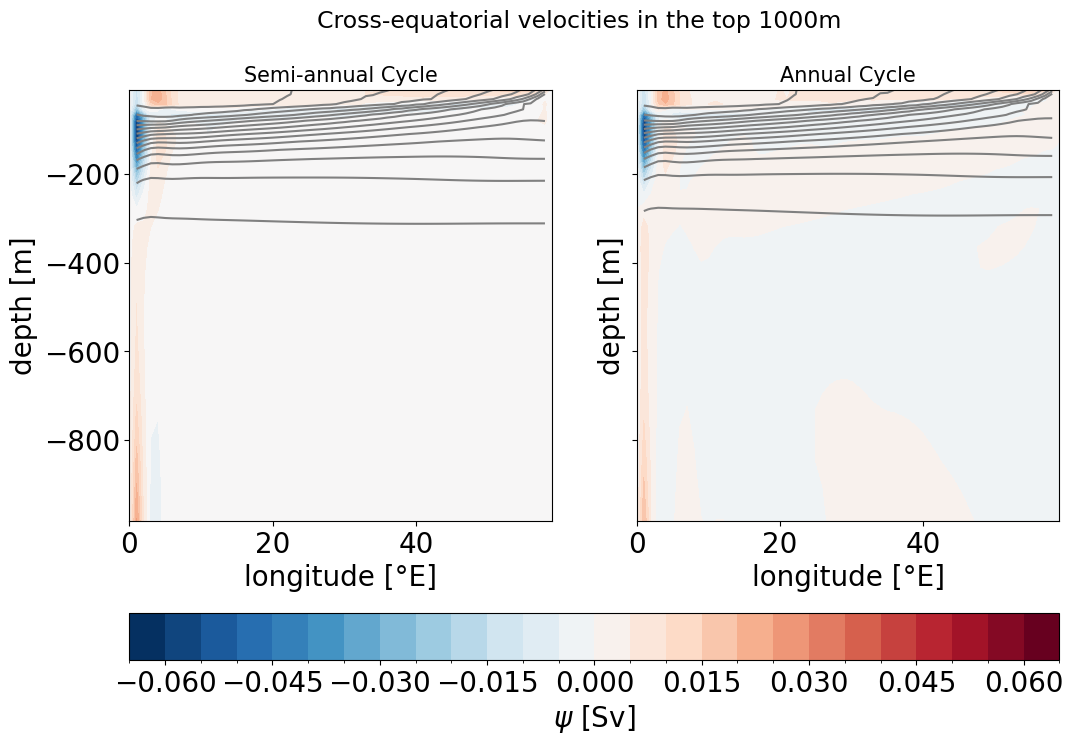

In [33]:
fig, axs = plt.subplots(1,2,figsize=(12,8), sharey=True)
a = (Data_annual.vocetr_eff.isel(t=-1, y_f=100, z_c=slice(0,25)) / 10e6).plot.contourf(x='x_c', y='depth_v', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[1])
Data_annual.sigma0.isel(t=-1, y_c=100, x_c=slice(1,-1), z_c=slice(0,25)).plot.contour(ax=axs[1], y='depth_t', colors='grey', levels=sigma_contours)
cbar1 = fig.colorbar(a, ax=axs[:2], location='bottom', label=r'$\psi$ [Sv]')
b = (Data_semi.vocetr_eff.isel(t=-1, y_f=100, z_c=slice(0,25)) / 10e6).plot.contourf(x='x_c', y='depth_v', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[0], vmin=cbar1.vmin, vmax=cbar1.vmax)
Data_semi.sigma0.isel(t=-1, y_c=100, x_c=slice(1,-1), z_c=slice(0,25)).plot.contour(ax=axs[0], y='depth_t', colors='grey', levels=sigma_contours)
axs[0].set_ylabel('depth [m]')
axs[1].set_ylabel('depth [m]')
axs[0].set_facecolor('grey')
axs[1].set_facecolor('grey')
axs[0].set_xlabel('longitude [°E]')
axs[1].set_xlabel('longitude [°E]')
axs[0].set_title('Semi-annual Cycle', fontsize=15)
axs[1].set_title('Annual Cycle', fontsize=15)
plt.suptitle('Cross-equatorial velocities in the top 1000m', fontsize=17)

In [34]:
sigma_contours = list(np.linspace(28.12,28.19,16))

Text(0.5, 0.98, 'Cross-equatorial velocities in the top 1000m')

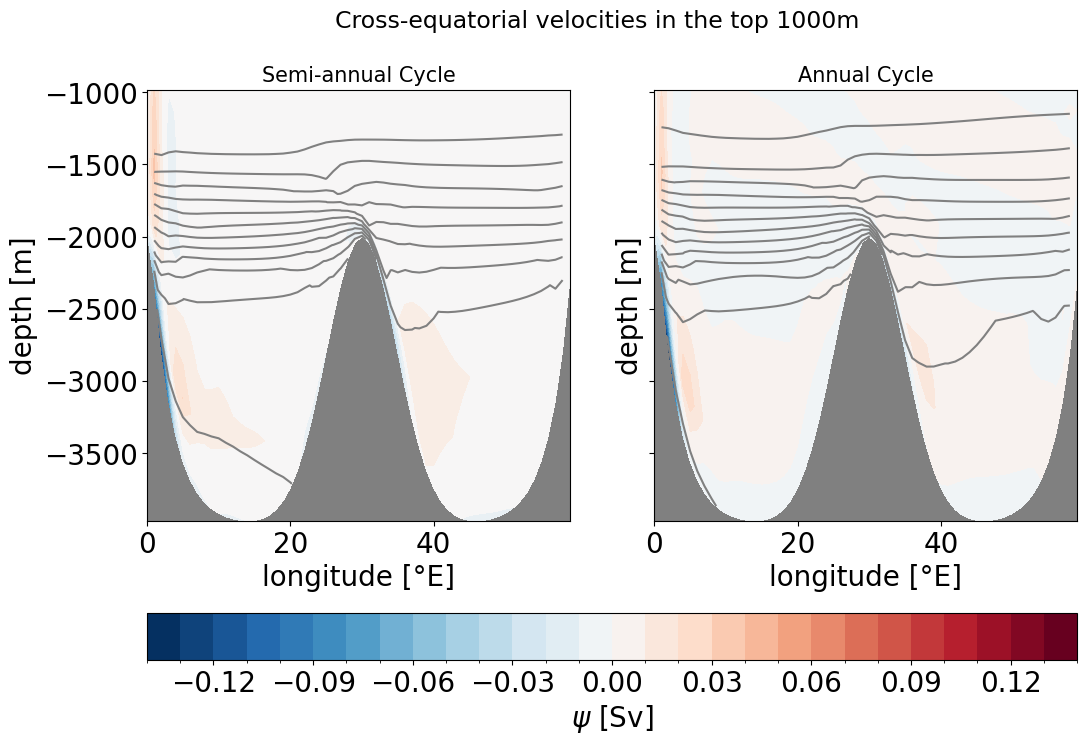

In [38]:
fig, axs = plt.subplots(1,2,figsize=(12,8), sharey=True)
a = (Data_annual.vocetr_eff.isel(t=-1, y_f=100, z_c=slice(24,-1)) / 10e6).plot.contourf(x='x_c', y='depth_v', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[1])
Data_annual.sigma0.isel(t=-1, y_c=100, x_c=slice(1,-1), z_c=slice(24,-1)).plot.contour(ax=axs[1], y='depth_t', colors='grey', levels=sigma_contours)
cbar1 = fig.colorbar(a, ax=axs[:2], location='bottom', label=r'$\psi$ [Sv]')
b = (Data_semi.vocetr_eff.isel(t=-1, y_f=100, z_c=slice(24,-1)) / 10e6).plot.contourf(x='x_c', y='depth_v', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[0], vmin=cbar1.vmin, vmax=cbar1.vmax)
Data_semi.sigma0.isel(t=-1, y_c=100, x_c=slice(1,-1), z_c=slice(24,-1)).plot.contour(ax=axs[0], y='depth_t', colors='grey', levels=sigma_contours)
axs[0].set_ylabel('depth [m]')
axs[1].set_ylabel('depth [m]')
axs[0].set_facecolor('grey')
axs[1].set_facecolor('grey')
axs[0].set_xlabel('longitude [°E]')
axs[1].set_xlabel('longitude [°E]')
axs[0].set_title('Semi-annual Cycle', fontsize=15)
axs[1].set_title('Annual Cycle', fontsize=15)
plt.suptitle('Cross-equatorial velocities in the top 1000m', fontsize=17)

### ACC strength

In [37]:
n_restarts = 8

In [52]:
#Combine restart files
for i in range(n_restarts-2, 0, -1):
    _datadir = Path(path + 'AnnualCycle/restart{}/'.format(i))
    _Data = xn.open_nemo(domcfg=domcfg_annual, files=[
        _datadir / 'NEVERWORLD_grid_T.nc',
        _datadir / 'NEVERWORLD_grid_U.nc',
        _datadir / 'NEVERWORLD_grid_V.nc'
    ])
    Data_annual = xr.concat([_Data.chunk(), Data_annual.chunk()], "t")

for i in range(n_restarts-2, 0, -1):
    _datadir = Path(path + '../NEVERWORLD/GAUS_RIDGE_init/restart{}/'.format(i))
    _Data = xn.open_nemo(domcfg=domcfg_semi, files=[
        _datadir / 'NEVERWORLD_grid_T.nc',
        _datadir / 'NEVERWORLD_grid_U.nc',
        _datadir / 'NEVERWORLD_grid_V.nc'
    ])
    Data_semi = xr.concat([_Data.chunk(), Data_semi.chunk()], "t")

/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[k

In [53]:
#Compute ACC transport
ACC_annual = Data_annual.isel(x_f=0).uocetr_eff.sum(['y_c', 'z_c']) / 1e6
ACC_semi = Data_semi.isel(x_f=0).uocetr_eff.sum(['y_c', 'z_c']) / 1e6

#OR!!!!
#ACC_annual = (Data_annual.isel(x_f=0).uoce * Data_annual.isel(x_f=0).e2u * Data_annual.isel(x_f=0).e3u).sum(['y_c', 'z_c']) / 1e6

In [54]:
import cftime as cft
ACC_annual = ACC_annual.assign_coords(dict({'t':cft.to_tuple(ACC_annual.indexes['t'])[0]}))
ACC_semi = ACC_semi.assign_coords(dict({'t':cft.to_tuple(ACC_semi.indexes['t'])[0]}))

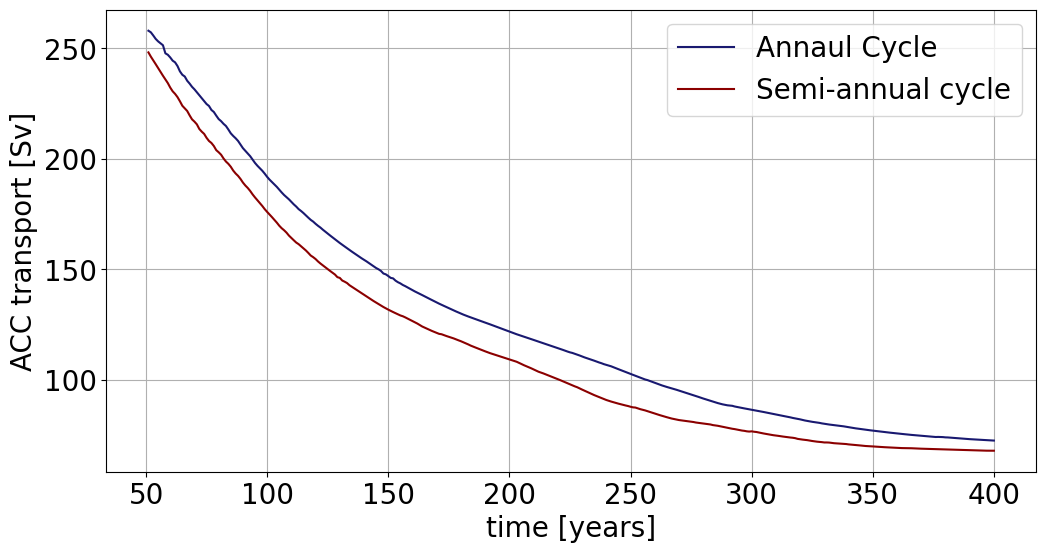

In [55]:
fig, axs = plt.subplots(1,1, figsize=(12,6))
ACC_annual.plot(color='midnightblue', label='Annaul Cycle')
ACC_semi.plot(color='darkred', label='Semi-annual cycle')
axs.set_ylabel('ACC transport [Sv]')
plt.title('')
plt.xlabel('time [years]')
plt.legend()
plt.grid()

### Monthly averaged MLD

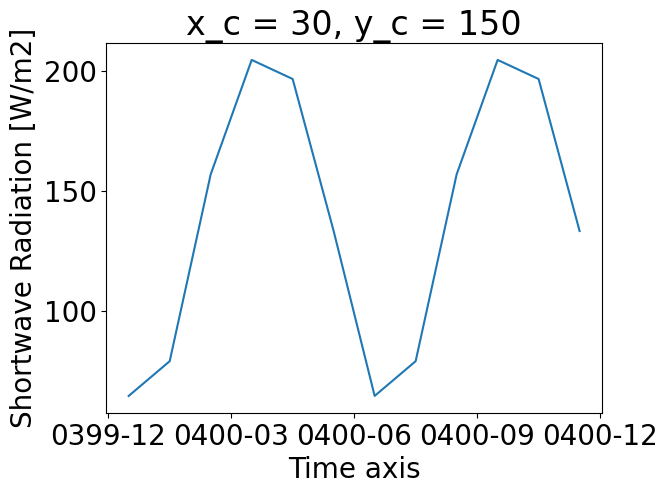

In [42]:
Data_semi_mo.qsr.isel(y_c=150, x_c=30, t=slice(-13,-1)).plot()

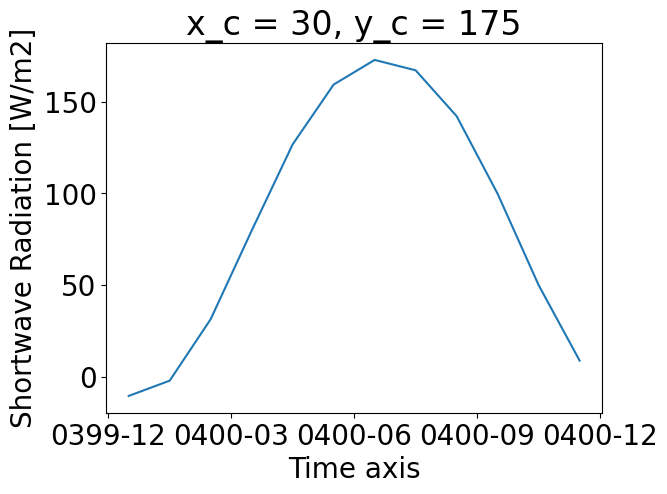

In [43]:
Data_annual_mo.qsr.isel(t=slice(-13,-1), x_c=30, y_c=175).plot()


## Meridional overturning

### Cutting the bottom cell and create a new grid object

In [44]:
import cf_xarray

Data_annual_cp = Data_annual.isel(z_c=slice(0,-1)).copy()
Data_semi_cp = Data_semi.isel(z_c=slice(0,-1)).copy()

level_outer_annual = cf_xarray.bounds_to_vertices(Data_annual_cp.deptht_bounds, 'axis_nbounds').load().data
level_outer_semi = cf_xarray.bounds_to_vertices(Data_semi_cp.deptht_bounds, 'axis_nbounds').load().data

Data_annual_cp = Data_annual_cp.assign_coords({'z_f': level_outer_annual})
Data_semi_cp = Data_semi_cp.assign_coords({'z_f': level_outer_semi})

grid_annual_cp = xgcm.Grid(Data_annual_cp,
    coords={
        "X": {"center": "x_c"},
        "Y": {"right": "y_f", "center":"y_c"},
        "Z": {"center": "z_c", "outer": "z_f"}
    },
    periodic=False)

grid_semi_cp = xgcm.Grid(Data_semi_cp,
    coords={
        "X": {"center": "x_c"},
        "Y": {"right": "y_f", "center":"y_c"},
        "Z": {"center": "z_c", "outer": "z_f"}
    },
    periodic=False)

### Compute potential density, referenced to 2000m

In [45]:
Data_annual_cp['sigma0'] = gsw.sigma0(Data_annual_cp.soce, gsw.CT_from_pt(Data_annual_cp.soce, Data_annual_cp.toce))
Data_semi_cp['sigma0'] = gsw.sigma0(Data_semi_cp.soce, gsw.CT_from_pt(Data_semi_cp.soce, Data_semi_cp.toce))

### Interpolate sigma2 on the cell faces

In [46]:
sigma_v_annual = grid_annual_cp.interp(Data_annual_cp.sigma0, 'Y')
sigma_outer_annual = grid_annual_cp.interp(sigma_v_annual, 'Z',  boundary='extend')

sigma_v_semi = grid_semi_cp.interp(Data_semi_cp.sigma0, 'Y')
sigma_outer_semi = grid_semi_cp.interp(sigma_v_semi, 'Z',  boundary='extend')

### Target values for the new density coordinates

In [47]:
import numpy as np
sigma_target = np.array([24, 24.2, 24.4, 24.65, 24.9, 25.15, 25.4, 25.65,
                        25.9, 26.15, 26.4, 26.57, 26.75, 26.90, 27.05, 27.17,
                        27.30, 27.37, 27.45, 27.52, 27.58,
                        27.63, 27.68, 27.72, 27.75, 27.78, 27.80, 27.815,
                        27.83, 27.845, 27.86, 27.875, 27.89,
                        27.905, 27.92, 27.935, 27.95, 27.965,
                        27.98, 27.99, 28.01, 28.025,
                        28.04, 28.055, 28.07, 28.085, 28.1, 28.35,
                        28.6, 28.8, 29.1])

### Transforming the meridional transport on density coordinates

In [48]:
vtra_annual = grid_annual_cp.transform(Data_annual_cp.vocetr_eff,
        'Z',
        sigma_target,
        method='conservative',
        target_data=sigma_outer_annual)

vtra_semi = grid_semi_cp.transform(Data_semi_cp.vocetr_eff,
        'Z',
        sigma_target,
        method='conservative',
        target_data=sigma_outer_semi)

/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_

### Computing the meridional overturning

In [49]:
Over_annual    = vtra_annual.isel(t=-1).sum(dim='x_c')[:,::-1].cumsum('sigma0') / 1e6
Over_semi    = vtra_semi.isel(t=-1).sum(dim='x_c')[:,::-1].cumsum('sigma0') / 1e6

In [50]:
Over_annual = Over_annual.assign_coords(dict({'y_f': domcfg_annual.gphif.isel(x_f=10).values}))
Over_semi = Over_semi.assign_coords(dict({'y_f': domcfg_semi.gphif.isel(x_f=10).values}))

Text(0.5, 1.0, 'Annual Cycle')

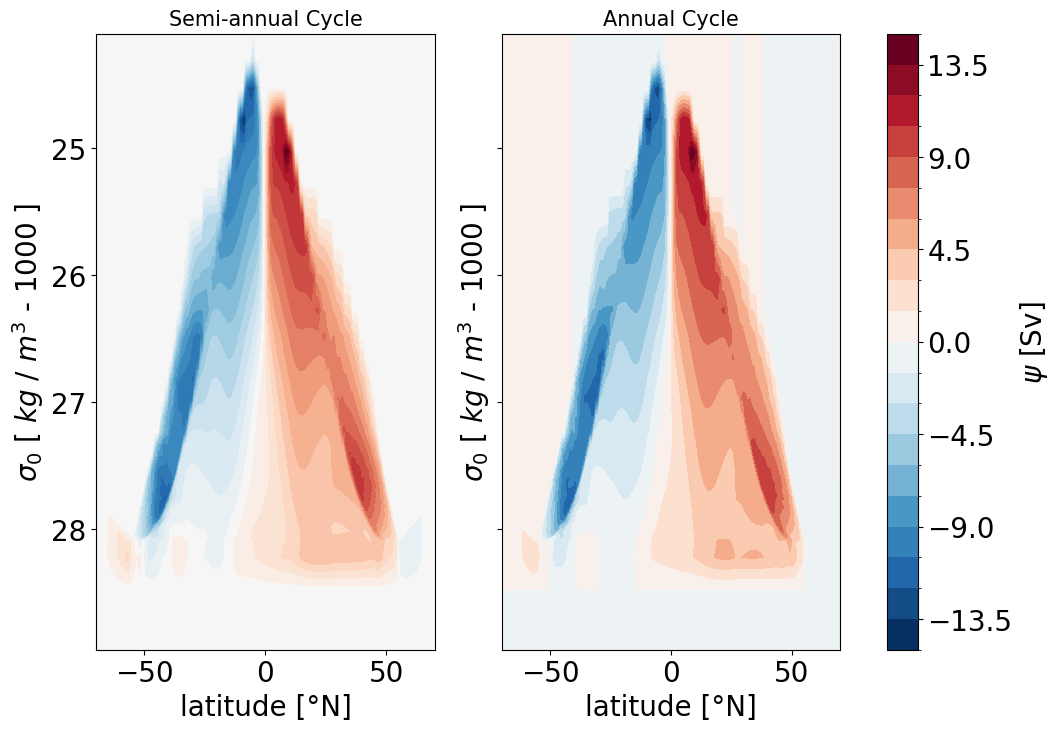

In [51]:
fig, axs = plt.subplots(1,2,figsize=(12,8), sharey=True)
a = (-Over_annual).plot.contourf(x='y_f', y='sigma0', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[1])
cbar1 = fig.colorbar(a, ax=axs, label=r'$\psi$ [Sv]')
b = (-Over_semi).plot.contourf(x='y_f', y='sigma0', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[0], vmin=cbar1.vmin, vmax=cbar1.vmax)
axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
axs[1].set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
axs[0].set_xlabel('latitude [°N]')
axs[1].set_xlabel('latitude [°N]')
axs[0].set_title('Semi-annual Cycle', fontsize=15)
axs[1].set_title('Annual Cycle', fontsize=15)

In [1]:
#!jupyter nbconvert --to html ./AnnualCycle.ipynb --HTMLExporter.theme=dark 

[NbConvertApp] Converting notebook ./AnnualCycle.ipynb to html
[NbConvertApp] Writing 2270884 bytes to AnnualCycle.html
